# Homework 2
### OPER 685 - Machine Learning I
### Hosley, Brandon


In [113]:
%load_ext ipydex.displaytools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise, pairwise_distances, silhouette_score, DistanceMetric
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy import stats
from math import sqrt


The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


## Problem 1.
(50 points) Suppose you are working with the 455th Air Expeditionary Wing at Bagram Airfield, Afghanistan. You are given a data set that contains information relating to 73 recent contingency and insurgency operations (e.g., terrain, number of personnel, lat/long coordinates, etc.). Your Division Chief has tasked you to display the data visually in a 2-dimensional space to see if any interesting insights can be obtained.

You have decided that MDS is the best tool to accomplish this task, so you compute a proximity matrix for the 73 operations. The resulting proximity matrix has been provided to you as bagram_ops.csv.   Download bagram_ops.csv. Use the classical MDS algorithm we learned in class (i.e., use matrix calculations not scikit learn) to visualize the data in two dimensions (25 Points for correct application).

In [4]:
bagram = pd.read_csv('bagram_ops.csv')
bagram_array = bagram.iloc[:,1:-1].to_numpy(dtype=float)
bagram_response = bagram.iloc[:,-1]

#### (a) (5 points) What are the two largest eigenvalues?

In [5]:
Q = (bagram_array**2)*(-0.5)

I = np.identity(len(bagram_array))
ones = np.ones((len(bagram_array),1))

H = I - 1/len(bagram_array)*np.dot(ones,ones.T)
B=H@Q@H

n = 2
eVals,eVecs=np.linalg.eig(B)
top_n_ind = np.argpartition(eVals, -n)[-n:]
eVals[top_n_ind] ##:

(eVals[top_n_ind]) := array([1.28448073, 2.43497663])

---

The two largest eigenvalues are  2.43497663 and 1.28448073.

#### (b) (5 points) Using the MDS generated coordinates, visualize the data in 2-dimensional space (Hint: use the response variable to label the data)

[Text(0.5, 1.0, '2D Principle Component MDS')]

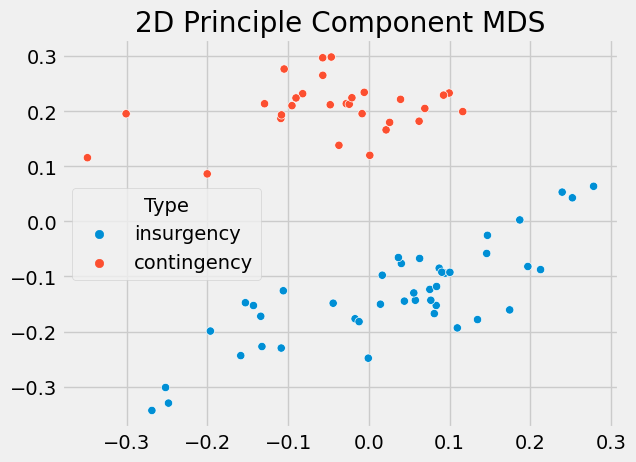

In [135]:
# Multiply the two largest eigenvaluess with each of the corresponding eigenvector elements
coords = eVecs[:,top_n_ind]@np.sqrt(np.diag(eVals[top_n_ind]))

# Plot in R^2 space
sns.scatterplot(x =coords[:,0], y =coords[:,1], hue=bagram_response).set(title='2D Principle Component MDS')

(c) (5 points) What insights can you obtain from the 2-dimensional plot?

Based on this plot it appears that there is a notable and clearly separable distance between the two responses. If the stress value is sufficiently low, we will also be able to conclude that the features provided will be sufficient to develop a fairly reliable model.

(d) (10 points) Assess the goodness-of-fit

- i. Compute and discuss the stress (Remember our in-class conversation about trusting scikit learns built in stress metric)
- ii. Generate and discuss the Shepard diagram

The Kruskal stress on this transformation is 0.7186963320755692


[Text(0.5, 1.0, 'Shepard Diagram'),
 Text(0.5, 0, 'Input Distance'),
 Text(0, 0.5, 'MDS Distance')]

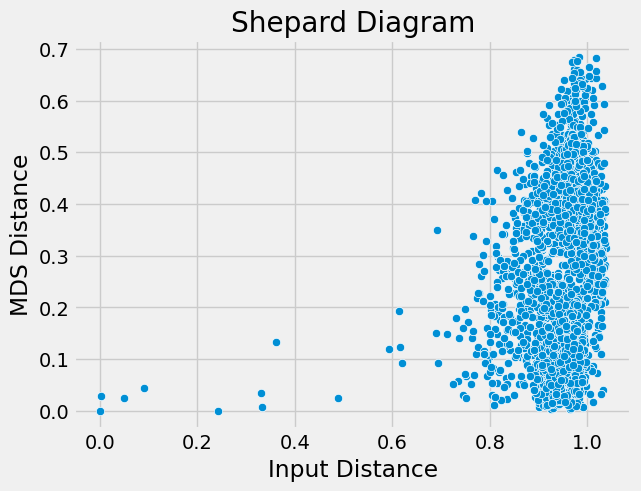

In [159]:
original_dist = ((bagram_array)).flatten()
scaled_dist = (pairwise.euclidean_distances(coords)).flatten()

stress = sqrt(sum((scaled_dist-original_dist)**2)/sum(original_dist**2))
print('The Kruskal stress on this transformation is', stress)

sns.scatterplot(x =original_dist, y =scaled_dist).set(title='Shepard Diagram', xlabel='Input Distance', ylabel='MDS Distance')

The Kruskal measurement is fairly high; higher than what would have been considered good by Kruskal's original scale. 
The Shepard diagram shows what appears to be a strong dispersion of the MDS distance relative to the input.
There may be some underlying relationship here, however, this strong clustering to the right does explain the high stress value.

## Problem 2.
(50 points) The file pottery.csv   Download pottery.csv contains data on the chemical composition of Roman-British pottery specimens. The chemical composition was determined by the atomic absorption spectrophotometry for nine oxides. In addition, the kiln site at which the pottery was found is provided.

In [48]:
pottery = pd.read_csv('pottery.csv')

pottery[['A1203', 'Fe203', 'Mg0', 'Ca0', 'Na20', 'K20', 'Ti02', 'Mn0', 'Ba0']] = \
    StandardScaler().fit_transform(pottery[['A1203', 'Fe203', 'Mg0', 'Ca0', 'Na20', 'K20', 'Ti02', 'Mn0', 'Ba0']])

pottery_comp =  pottery[['A1203', 'Fe203', 'Mg0', 'Ca0', 'Na20', 'K20', 'Ti02', 'Mn0', 'Ba0']]
pottery_kiln = pottery[['Kiln']]

pottery.head()

,Item,A1203,Fe203,Mg0,Ca0,Na20,K20,Ti02,Mn0,Ba0,Kiln
0,1,1.156502,1.582131,-0.283543,0.615412,0.891397,-5.266728e-16,0.749900,0.140215,-0.512482,1
1,2,0.445640,0.661549,-0.486719,0.726720,0.891397,-1.778942e-01,0.637415,-0.075870,0.504945,1
2,3,0.932019,0.791859,-0.388034,0.570888,0.891397,-1.541750e-01,0.581173,0.356299,-0.851624,1
3,4,0.445640,0.644734,-0.538964,0.548627,0.891397,-1.778942e-01,0.693658,-0.162303,0.844088,1
4,5,0.782364,0.623716,-0.382229,0.904813,1.061608,-9.487693e-02,0.299960,-0.205520,0.844088,1


(a) (10 points for correct application) Perform k-means cluster analysis on the data set.

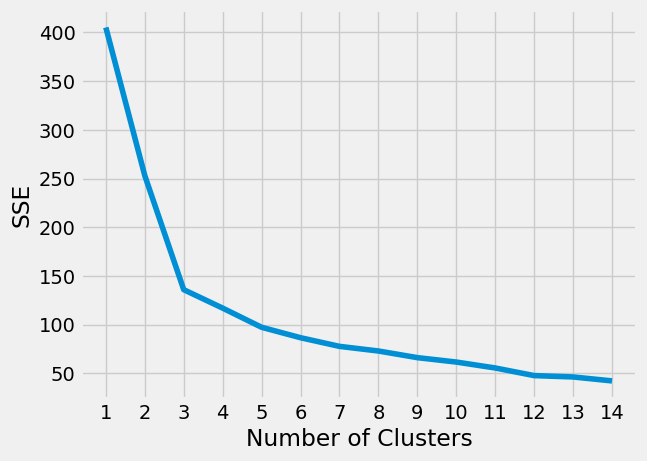

In [49]:
## Code from OPER 685 Lesson 7

# A list holds the SSE values for each k
m = 15
sse = []
for k in range(1, m):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init=10, max_iter=300)
    kmeans.fit(pottery_comp)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, m), sse)
plt.xticks(range(1, m))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

(b) (5 points) Can the pots in the data set be divided into distinct groups using cluster analysis?

Based on the large drop in error over the initial increase to three clusters, it suggests that the data may be clustered into distinct groups, further analysis is necessary to determine if this distinction can be made in some meaningful way regarding the response variable.

(c) (5 points) If so, how do these groups relate to the kiln site?

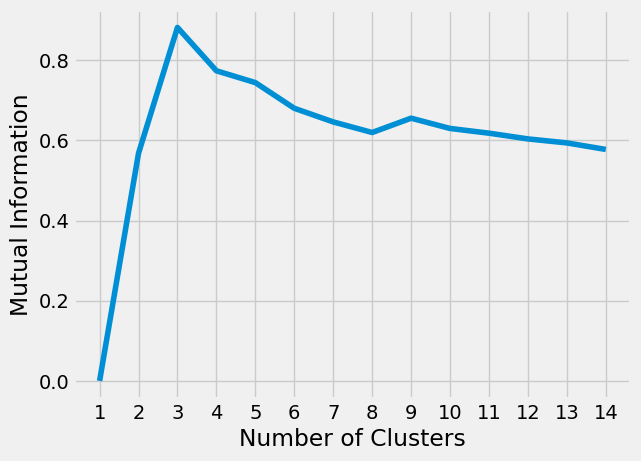

In [132]:
mis = []
for k in range(1, m):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init=10, max_iter=300)
    kmeans.fit(pottery_comp)
    mis.append(normalized_mutual_info_score(kmeans.labels_, pottery_kiln.to_numpy().flatten()))

plt.style.use("fivethirtyeight")
plt.plot(range(1, m), mis)
plt.xticks(range(1, m))
plt.xlabel("Number of Clusters")
plt.ylabel("Mutual Information")
plt.show()

From this analysis the measurement of mutual informaiton suggests that the strength of association between clusters and kiln labels peaks at three clusters.
This may suggest that there is some association between kiln sites and the clusters, but there are some sites that cannot be effectively separated by cluster, two of the sites are closely positioned with one or two other sites.

(d) (5 points) Compute and plot the within-cluster-sum of squared errors (WCSS) for different k values. What insights does this plot give you?

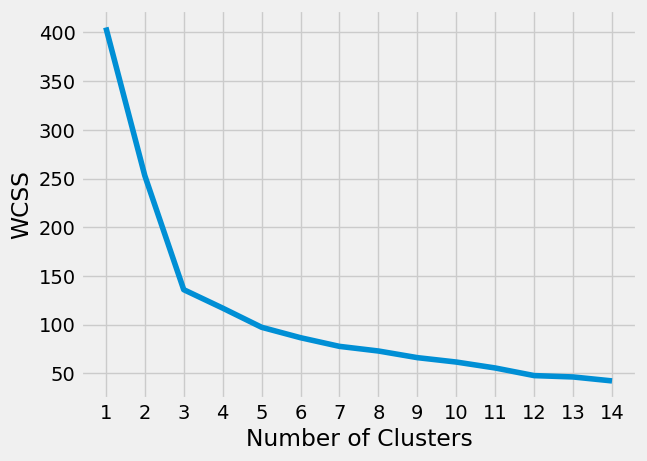

In [109]:
def compute_wcss(model, data):
    centroids = np.empty(data.shape)
    for i in range(len(model.labels_)):
        centroids[i] = model.cluster_centers_[model.labels_[i]]
    error = pairwise.paired_distances(X= centroids, Y= data.to_numpy())
    return np.sum(np.square(error))

wcss = []
for k in range(1, m):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init=10, max_iter=300)
    kmeans.fit(pottery_comp)
    wcss.append(compute_wcss(kmeans,pottery_comp))

plt.style.use("fivethirtyeight")
plt.plot(range(1, m), wcss)
plt.xticks(range(1, m))
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

After developing a method for computing the WCSS and recieving results identical to the SSE and kmeans inertia plot, it suggests that I have either written the function incorrectly; or that I have just now made the connection between the two measurements. 

Following the elbow method, the largest change in slope appears to occur at 3 clusters, suggesting that this may be a good candidate number.

(e) (5 points) What are the average silhouette scores for k = 2, 3, 4, 5, 6? What insights does this give you?

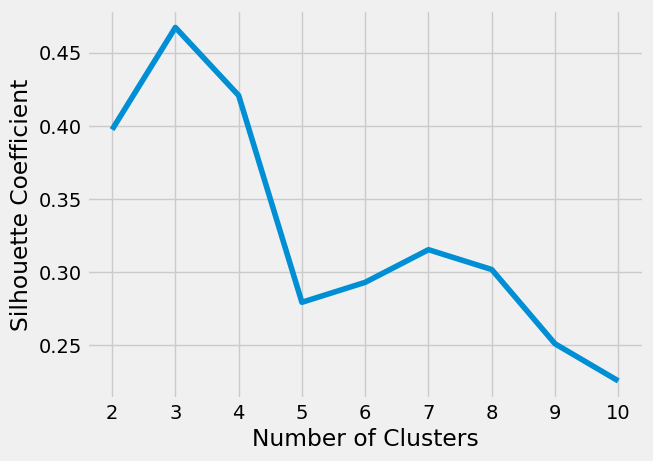

In [110]:
range_n_clusters = [2, 3, 4, 5, 6]

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k,n_init="auto")
    kmeans.fit(pottery_comp)
    score = silhouette_score(pottery_comp, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

(f) (10 points for correct application) Visualize your data in two dimensions via PCA. Color your data points according to the assigned cluster.

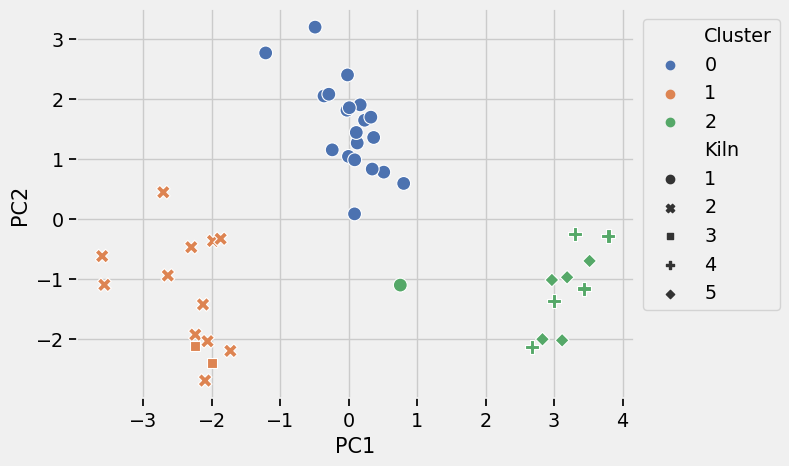

In [155]:
pca = PCA(n_components=2)
pca_pot = pca.fit_transform(pottery_comp)
pc_df = pd.DataFrame(data = pca_pot, columns = ['PC1', 'PC2'])

kmeans = KMeans(n_clusters=3,n_init="auto")
kmeans.fit(pc_df)

pc_df['Cluster'] = kmeans.labels_
pc_df['Kiln'] = pottery_kiln

with sns.plotting_context('notebook',font_scale=1.25):
    sns.scatterplot(x='PC1', y='PC2',
                    data=pc_df, 
                    hue='Cluster',
                    style='Kiln',
                    palette='deep',
                    s=100)
    plt.legend(loc='best',bbox_to_anchor=(1, 1))

(g) (10 points) What insights can you obtain from this plot?

This plot suggests that based on the two components with the highest explanability, the artifacts from the five kilns are likely to be easily attributed to one of three clusters. Two of those clusters each contain samples from two kilns that are not likely distinquishable within the two component constraint. 